In [1]:
#No58(正則化パラメータの変更)
import pandas as pd
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
drive.mount('/content/drive')
!wget https://archive.ics.uci.edu/static/public/359/news+aggregator.zip
!unzip news+aggregator.zip
df = pd.read_csv("./newsCorpora.csv",sep="\t",header=None,names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])
#「PUBLISHER」の行から、”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
#isinはあくまでbool値を返すことに注意(Trueが抽出される)
df = df[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]
#「TITLE」と「CATEGORY」の列を抽出する．
df = df[["TITLE", "CATEGORY"]]
#学習、検証、評価データに分割する(分割したいもの、割合、shuffleはTrueがデフォルト)
#まず0.9:0.1で分ける
train, test = train_test_split(df, test_size=0.2)
#次に0.2を半分にする(検証、評価データを0.1にする)
test, valid = train_test_split(test, test_size=0.5)

Mounted at /content/drive
--2024-06-07 11:23:01--  https://archive.ics.uci.edu/static/public/359/news+aggregator.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘news+aggregator.zip’

news+aggregator.zip     [   <=>              ]  27.87M  46.1MB/s    in 0.6s    

2024-06-07 11:23:02 (46.1 MB/s) - ‘news+aggregator.zip’ saved [29224203]

Archive:  news+aggregator.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
def preprosessing(text):
    #string.punctuation 「'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'」のこと
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    #maketransで作成したtableを文字列を変換する
    text = text.translate(table)
    #小文字にする
    text = text.lower()
    #正規表現を利用するために、compileを用いてpatternを作成する
    pattern = re.compile('[0-9]+')
    #正規表現にマッチした部分に0を代入
    text = re.sub(pattern, '0', text)

    return text

#データの連結、前処理
df = pd.concat([train, valid, test], axis = 0)
#もとのindexを削除
df.reset_index(drop=True, inplace=True)

df['TITLE'] = df['TITLE'].map(lambda x: preprosessing(x))
#データの連結、前処理
df = pd.concat([train, valid, test], axis = 0)
df.reset_index(drop=True, inplace=True)
#map関数　シーケンスの構成要素すべてに対して、ある関数の処理を行わせるという高階関数
#lambda関数を用いて、xを引数として、preprosessing関数を呼び出す
df['TITLE'] = df['TITLE'].map(lambda x: preprosessing(x))
vec_tfidf = TfidfVectorizer() #TfidfVectorizerのインスタンス生成
data = vec_tfidf.fit_transform(df['TITLE'])
data = pd.DataFrame(data.toarray(), columns = vec_tfidf.get_feature_names_out())
#整数除算をして、dataを分割する。
split_point1 = int(len(data)//3)
split_point2 = int(split_point1 * 2)
#学習、検証、評価データ
x_train = data[:split_point1]
x_valid = data[split_point1:split_point2]
x_test = data[split_point2:]
#学習、検証、評価等別
y_data = df['CATEGORY']
y_train = y_data[:split_point1]
y_valid = y_data[split_point1:split_point2]
y_test = y_data[split_point2:]

正則化パラメータ: 0.001
正解率(訓練データ): 0.4143049932523617
正解率(検証データ): 0.42645074224021595
正解率(テストデータ): 0.42468525179856115
----------------------------------------
正則化パラメータ: 0.01
正解率(訓練データ): 0.7332433648223122
正解率(検証データ): 0.7123256860098965
正解率(テストデータ): 0.7185251798561151
----------------------------------------
正則化パラメータ: 0.1
正解率(訓練データ): 0.7768780926675664
正解率(検証データ): 0.7780026990553306
正解率(テストデータ): 0.7733812949640287
----------------------------------------
正則化パラメータ: 1
正解率(訓練データ): 0.9327485380116959
正解率(検証データ): 0.8502024291497976
正解率(テストデータ): 0.8455485611510791
----------------------------------------


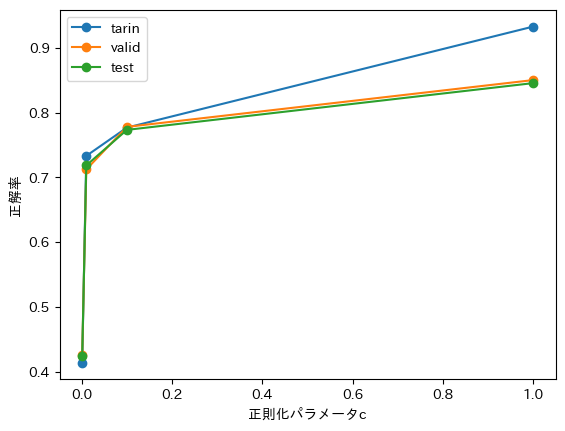

In [6]:
#install忘れずに
!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# cごとの正解率を格納(縦軸)
accuracies_train = []
accuracies_valid = []
accuracies_test = []

# cは正則化パラメータ
c_list = [0.001, 0.01, 0.1, 1]

for c in c_list:
    #再現性を担保するために、random_stateに適当なシード値を入れる
    model = LogisticRegression(C = c, random_state = 0)
    #学習
    model.fit(x_train, y_train)

    # 訓練データ
    y_pred_train = model.predict(x_train)
    accuracy_train = accuracy_score(y_pred_train, y_train)
    accuracies_train.append(accuracy_train)

    #検証データ
    y_pred_valid = model.predict(x_valid)
    accuracy_valid = accuracy_score(y_pred_valid, y_valid)
    accuracies_valid.append(accuracy_valid)

    #テストデータ
    y_pred_test  = model.predict(x_test)
    accuracy_test = accuracy_score(y_pred_test, y_test)
    accuracies_test.append(accuracy_test)

    print(f'正則化パラメータ: {c}')
    print(f'正解率(訓練データ): {accuracy_train}')
    print(f'正解率(検証データ): {accuracy_valid}')
    print(f'正解率(テストデータ): {accuracy_test}')
    print('-'*40)
#o circleのこと
plt.plot(c_list, accuracies_train, label = 'tarin', marker = 'o')
plt.plot(c_list, accuracies_valid, label = 'valid', marker = 'o')
plt.plot(c_list, accuracies_test, label = 'test', marker = 'o')
plt.xlabel('正則化パラメータc')
plt.ylabel('正解率')
#凡例のこと
plt.legend()
#表示
plt.show()
#今回はデフォルトのｃ＝１が、すべてのデータにおいて精度が高かった。